In [ ]:
###PART 1
#Question 1
import Bio.PDB as PDB
import os

def extract_res(n, directory = "top100H"):
    '''Takes in a value n and a directory. Returns a dictionary with entries for all files in the directory. 
    Each dictionary entry contains a list of polypeptide segments of length n.'''
    #create parser
    parser = PDB.PDBParser(QUIET = True) #Quiet ignores warnings
    #create polypetide builder
    pp_builder = PDB.PPBuilder() #build polypeptides to ensure the AAs are connected

    res_dict = {} #list of all 9 residues
    for filename in os.listdir(directory): #loop through all files in directory
        try:
            structure = parser.get_structure(filename, os.path.join(directory, filename)) #create structure
            pp_list = pp_builder.build_peptides(structure) #create list of polypeptides for each structure
            ll = [] #list of sublists
            for pp in pp_list: #for every polyeptide in the list of polypeptides:
                for i in range(len(pp)-(n-1)): #ignore last 8 amino acids
                    #if PDB.is_aa(pp[i], standard=True): #check if polypeptide is a standard AA
                    sublist = pp[i:i+n] #create sublist of 9 AAs
                    if check_true(sublist):
                        ll.append(sublist) #for every protein, group together all the sublists
            res_dict[filename] = ll #store the list of sublists into the corresponding protein entry
        except (TypeError, ValueError) as e: #check for type errpr and value erorr
            print("Could not parse", filename)
    return res_dict

def check_true(AAs_list):
    t = 0
    for i in AAs_list:
        if PDB.is_aa(i, standard=True):
            t+=1
    if t == 9:
        return True
    else:
        return False

In [2]:
residue_segments = extract_res(9)

Could not parse 1etmH
Could not parse 2mhrH


In [3]:
#Question 2
import random
import numpy as np

def select_one(AA, prot):
    '''For a given AA, this function selects one random fragment 
    with the central AA from a list of fragments'''
    frag_list = []
    for frag in prot:
        if frag[4].get_resname() == AA: #Checks for middle amino acid
            frag_list.append(frag)
        elif AA == "N": #If the AA is N, then it will not select for any amino acid
            frag_list.append(frag)
    if len(frag_list) == 0: #If the protein has no fragments, an empty list is retured (to fix a bug)
        return []
    random_frag = random.choice(frag_list)
    c = []
    for res in random_frag:
        for atom in res:
            if atom.get_id() == "CA" or atom.get_id() == "C" or atom.get_id() == "N":
                c.append(atom.get_coord())
    if np.shape(c) != (27, 3): #Some residues have less than 9 backbone atoms, this check ignores them
        return []
    else:
        return random_frag

def select_pair(AA, res_dict):
    '''For a given AA, this function returns a pair of fragments 
    each with a central AA from a dictionary of fragment lists'''
    prot_list = list(res_dict.keys()) #create list of protein names
    frag1 = []
    frag2 = []
    while True: #loops forever
        prot1 = random.choice(prot_list) #select 1 random protein
        frag1 = select_one(AA, residue_segments[prot1]) #select 1 fragment from that protein
        if len(frag1) == 0:
            prot_list.remove(prot1) #if there are zero fragments, remove that protein from future searches
        else:
            prot_list.remove(prot1) #protein 1 is selected, so remove it so that it is not selected for protein 2
            prot2 = random.choice(prot_list)
            frag2 = select_one(AA, residue_segments[prot2])
            if len(frag2) == 0:
                prot_list.remove(prot2) #if there are zero fragments, remove that protein from future searches
            else:
                prot_list = list(res_dict.keys())
                break #both fragments are found so stop loop
    pair = [frag1, frag2]
    return(pair)

def get_center(m):
    c = (3*5) - 2
    m_ca = m[:,c]
    centered_m = m - m_ca
    return(centered_m)

def RMSD(a, b, manual = False):
    '''This function takes in two matrices, each containing all the
    coordinates of a protein and returns the transformation matrix
    and the RMSD value'''
    #center a and b
    centered_a = get_center(a)
    centered_b = get_center(b)

    #calculate n
    n = np.size(centered_a)/len(centered_a)

    #calculate R
    R = centered_b * centered_a.T

    #SVD
    V, S, W_t = np.linalg.svd(R)
    
    #Calculate U
    U = W_t.T * V.T

    #check if U is a reflection (-1)
    if round(np.linalg.det(U)) == -1 :
        Z = np.diag([1,1,-1])
        U = W_t.T * Z * V.T #reflect U so that it is no longer a reflection
        S = -S[2]

    if manual == False:
        #calculate E_0 and n
        E_0 = np.linalg.norm(centered_a)**2 + np.linalg.norm(centered_b)**2

        #calculate RMSD using the formula
        RMSD = np.sqrt(1/n * (E_0 - 2 * sum(S)))
        return(RMSD)
    else:
        #Rotate B
        rotated_b = U * centered_b
        #manually calculate RMSD of a and rotated b
        man_RMSD = np.sqrt((1/n) * np.linalg.norm(centered_a - rotated_b)**2)
        return(man_RMSD)

def get_coord(structure):
    '''Converts a list of residues, into a matrix of coordinates'''
    backbone = ["CA", "C", "N"] #get coordinates for these atoms
    coord_list = []
    for residue in structure:
        if PDB.is_aa(residue) == True: #check if the residue is an animo acid
            for atom in residue.get_atoms():
                if atom.get_id() in backbone: #check if the atom is a backbone atom
                    coord_list.append(atom.get_coord()) #get the coridnate of the atom and append to the list
    coord_matrix = np.matrix(coord_list).T #Turn the list into a matrix and transpose it
    return coord_matrix

def RMSD_AA(AA_list, res_dict, n = 500):
    RMSD_dict = {}
    PRO_pair = []
    PRO_R = []
    for AA in AA_list:
        RMSD_list = []
        for i in range(n):
            pair = select_pair(AA, res_dict)
            coord1 = get_coord(pair[0])
            coord2 = get_coord(pair[1])
            RMSD_val = RMSD(coord1, coord2)
            RMSD_list.append(RMSD_val)
            if AA == "PRO":
                PRO_pair.append(pair)
                PRO_R.append(RMSD_val)
        RMSD_dict[AA] = RMSD_list
    return (RMSD_dict, PRO_R, PRO_pair)

In [4]:
AAs = ["ALA", "GLY", "PRO", "PHE", "ASP", "ARG", "LEU", "N"]
tup = RMSD_AA(AAs, residue_segments)
AAs_RMSD = tup[0]

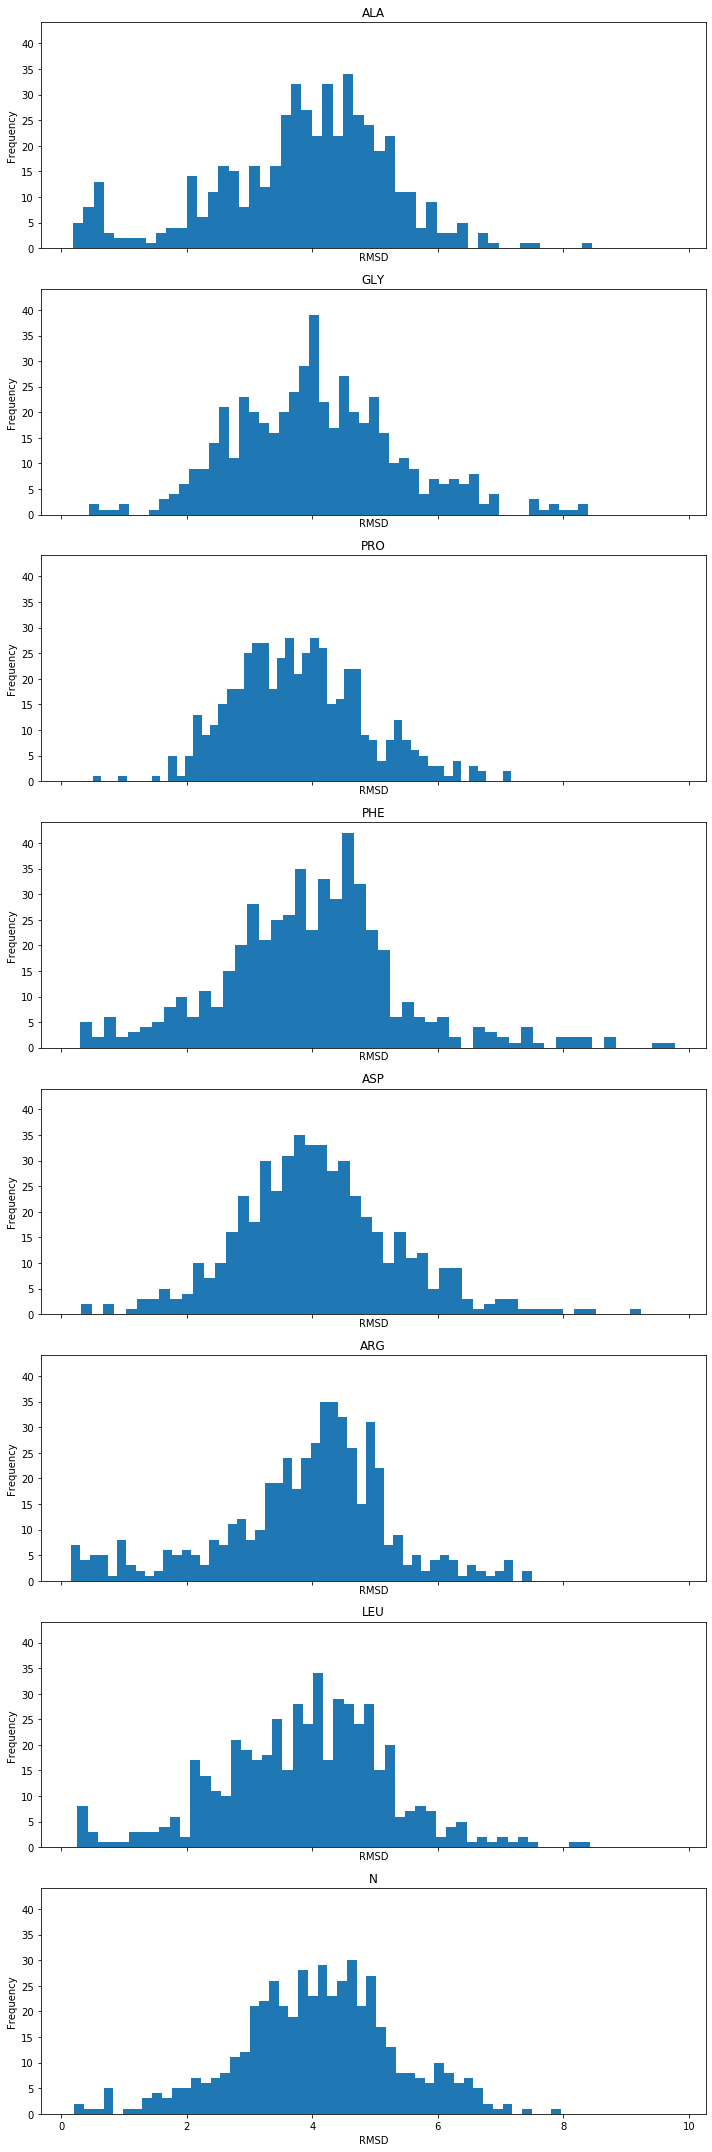

In [6]:
#Question 3
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots(8, 1, sharey=True, sharex=True, tight_layout=True, figsize=(10, 30))

for i in range(len(AAs)):
    axs[i].hist(AAs_RMSD[AAs[i]], bins=50)
    axs[i].set_title(AAs[i])
    axs[i].set_xlabel("RMSD")
    axs[i].set_ylabel("Frequency")

In [82]:
#Question 4
#Completed in previous question


In [7]:
#Question 5
PRO_R = tup[1]
PRO_pairs = tup[2]
sorted_PRO_R = sorted(PRO_R)
min_6 = sorted_PRO_R[0:6]
min_6_pairs = []
for i in range(len(min_6)):
    index = PRO_R.index(min_6[i])
    min_6_pairs.append(PRO_pairs[index])
#print(min_6_pairs)
###save these as pdb files so that pymol can load them and superimopose them.

In [8]:
#export 1 pair to test on pymol
#then figure out how to do the rest
min_6_pairs[0]

[[<Residue GLU het=  resseq=70 icode= >,
  <Residue CYS het=  resseq=71 icode= >,
  <Residue TRP het=  resseq=72 icode= >,
  <Residue CYS het=  resseq=73 icode= >,
  <Residue PRO het=  resseq=74 icode= >,
  <Residue PHE het=  resseq=75 icode= >,
  <Residue GLY het=  resseq=76 icode= >,
  <Residue PHE het=  resseq=77 icode= >,
  <Residue GLU het=  resseq=78 icode= >],
 [<Residue THR het=  resseq=278 icode= >,
  <Residue LYS het=  resseq=279 icode= >,
  <Residue VAL het=  resseq=280 icode= >,
  <Residue VAL het=  resseq=281 icode= >,
  <Residue PRO het=  resseq=282 icode= >,
  <Residue ILE het=  resseq=283 icode= >,
  <Residue ASP het=  resseq=284 icode= >,
  <Residue ALA het=  resseq=285 icode= >,
  <Residue ILE het=  resseq=286 icode= >]]

In [ ]:
###PART 2
#Question 1